In [8]:
import numpy as np
import matplotlib.pyplot as plt
from importlib import reload
import geometry as Geometry
import environment as Env
import ray as Ray
import simulation as Sim

In [9]:
reload(Geometry)
reload(Env)
reload(Ray)
reload(Sim)

<module 'simulation' from '/Users/anatole/Documents/GitHub/ray-tracer/simulation.py'>

In [10]:
# Source setup
source = Geometry.Point2D(0., 0.)
angle = -0.5

In [14]:
env = Env.Environment2D(
    floor=lambda x: -550 * np.ones_like(x),
    ceiling=lambda x: 0 * np.ones_like(x)
)

In [15]:
reload(Ray)
ray = Ray.Ray2D(env, source, angle)
ray.propagate()

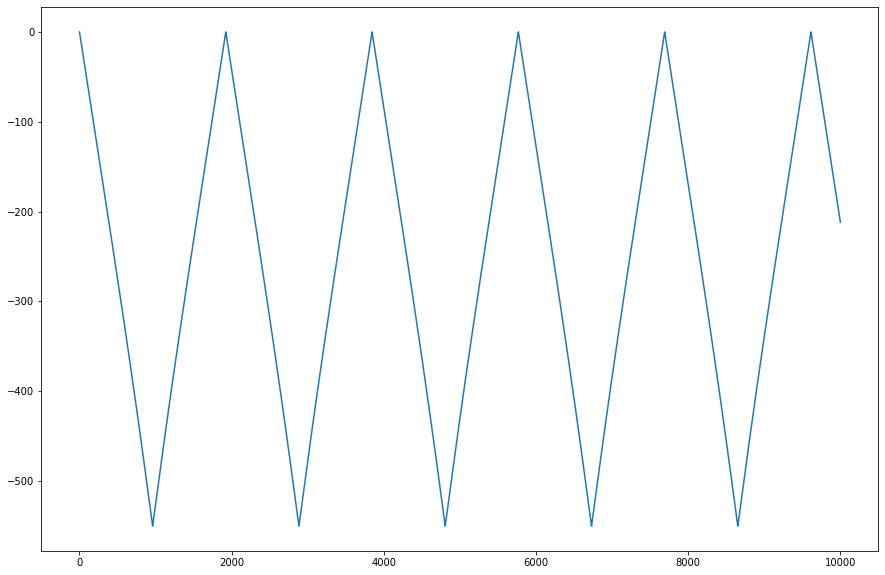

In [16]:
plt.figure(figsize=(15, 10))
plt.plot(ray.X, ray.Z)
plt.show()